# Notebook 04: Modeling - Keras Embeddings

## Contents:
1. [Summary](#section1)
2. [Dropping or Amending Lyrics](#section2)
3. [Cleaning Lyrics](#section3)
4. [Song Structure Analysis](#section4)
5. [Plotting](#section5)
6. [Lyric Structure Analysis](#section6)

# Summary
In this notebook I will build out a LSTM model in Keras that will take a sequence of tokenized words and predict an output. The input layer will be a Keras Embedding layer that will learn the relationships between words as the model trains, adding a layer of cohesion and an additional level of depth to the predictions. After building the model, I'll fit it on the dataset, review the training history, and finally predict on user-generated input strings.

Importing the necessary libraries.

In [3]:
import json, time, re, string, keras, pickle, adanet
import pandas as pd
import numpy as np
import tensorflow as tf

from numpy import random

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%run ../assets/sql_cred.py

Using TensorFlow backend.


Since this is being run on an AWS EC2 GPU instance, I am verifying that the GPU is being recognized by the kernal.

In [1]:
print(tf.test.gpu_device_name())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


Reading in the data

In [ ]:
X_reshape = np.load('../assets/1549351379_LSTM315_Xreshape.npy')

In [8]:
y_cat_coo = sparse.load_npz('../assets/1549351379_LSTM315_ycat.npz')

In [9]:
y_cat = y_cat_coo.toarray()

In [12]:
with open('../assets/1549351379_LSTM315_53tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

Saving vocab_size to the local namespace so it can be referenced as the output shape for the final layer of my model.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

## Building the Model

LSTM models have shown great performance for NLP processes such as text generation. They build on the framework of recurrent neural networks (RNN) by adding an additional cell state that allows the model to tune how data persists over time. This helps address one of the shortcomings of more simple RNNs - the vanishing gradient problem where data occurring earlier in the dataset becomes less likely to be considered when making predictions. This persistence is balanced by a 'forget gate' which allows data to be selectively dropped from memory. As the model trains on the input data these parameters are tuned to optimize predictions based on a given loss function. 

Because I want the model to understand the relationship between words, not just from a context but also from content, I am setting the input layer as an Embedding layer. This will be initialized with random weights that will be optimized as the model fits. This hope is that adding this additional layer of meaning will support better predictictions with user generated seed inputs. Since the vocabulary is relatively large, I'm starting with a relatively modest densification of the data with a 3000 feature embedding space.

The embedding layer will then be passed to the first LSTM layer. This layer will consist of 300 nodes and allow sequences to be passed to the next LSTM layer of 150 nodes. This aspectct is important as it relates to the core functional difference between LSTM and traditional RNN layers. Without the ability to pass sequences downstream the first layer would effectctively function like a leaky RNN. 

The second LSTM layer will pass the data to a dense layer with 100 nodes and a relu activation function. The idea here is that the model is wide enough in the early layers to pick out important features without overtraining and just returning an existing lyric or loop. By starting with 3000 features and narrowing as data moves downstream, there will be a funnel effect resulting in more generalizable predictions that account for a broader understanding of relationship in the data.

Finally, the output layer will be a softmax activated dense layer with the same shape as the input vocabulary. This will allow for predictions tied back to the initial corpus. The model will be optimized with ADAM, an adaptive gradient descent function with randomized initialization points which allows it to be faster and generally more effective than other optimization algorithms. Finally, the model will be assessed on accuracy based on the ground truth of actual next words in the track.

In [16]:
# Compile model
model = Sequential()
model.add(Embedding(vocab_size, 3000, mask_zero=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

The model will be run on GPU with a relatively large batch size of 10000 sequences over 150 epochs. This is somewhat modest considering the model is being fit without the foundation of pre-trained word vectors. Considering the size of the dataset, nearly 600000 sequences, this will allow for a reasonable starting point to assess model architecture before moving toward potentially more complex or time consuming systems.

In [19]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=10000,
              epochs=150, 
             )

Epoch 1/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.9092 - acc: 0.1141
Epoch 2/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.8179 - acc: 0.1237
Epoch 3/150
576641/576641 [==============================] - 91s 157us/step - loss: 5.8075 - acc: 0.1237
Epoch 4/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7988 - acc: 0.1237
Epoch 5/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7914 - acc: 0.1237
Epoch 6/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7862 - acc: 0.1237
Epoch 7/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7787 - acc: 0.1237
Epoch 8/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7686 - acc: 0.1237
Epoch 9/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7573 - acc: 0.1237
Epoch 10/150
576641/576641 [===========================

The training output shows that the model was fit on 576641 samples to an accuracy of 81.05%. 

Saving out the model for future predictions

In [20]:
formatted_name, now, file_description= filename_format_log('../assets/LSTM315_model.h5')

model.save(formatted_name)

In [21]:
formatted_name, now, file_description= filename_format_log('../assets/LSTM315_weights.h5')
model.save_weights(formatted_name)

In [ ]:
# model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')

Reviewing the model summary. 

In [22]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 3000)        40410000  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 300)         3961200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 13470)             1360470   
Total params: 46,017,370
Trainable params: 46,017,370
Non-trainable params: 0
_________________________________________________________________
None


The model summary shows that the model trained on just over 46000000 parameters. Due to the shape of the input layer, nearly 40000 of these were in the vectorized word embeddings.

Plotting training loss alongside training accuracy. 

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

# Generating Predictions

In [32]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [34]:
def generate_lyrics(seed, 
                    seq_len = 4, 
                    song_len = 50,
                    temperature = 1.0,
                    model = None,
                    tokenizer = None,
                    model_dir = None, 
                    tokenizer_dir = None):
    
    if model_dir:
        model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')
    else:
        model = model
    
    if tokenizer_dir: 
        with open('../assets/1549307085_190204_tokenizer.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        tokenizer = tokenizer
    
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = [seed_clean]
        sequence = [tokenizer.texts_to_sequences([word])[0] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, (1, seq_len))

        yhat = model.predict(sequence_reshape, verbose=0)[0]
        next_index = sample(yhat, temperature)
        
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

In [31]:
def lyric_grid(track):
#     track = df.loc[track_id, 'clean_lyrics']
    
    lyrics_spaced = re.sub(r'( +)', ' ', track)
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    
    N = len(lyrics_split)
    grid = np.zeros(shape=(N,N), dtype='int')
    
    for i in range(N):
        hits = [j for j, word in enumerate(lyrics_split) if word == lyrics_split[i]]
        grid[i,[hits]] = 1 
    
    plt.figure(figsize=(16,12))
    plt.title('Repetition in Track');
    plt.xlabel('Word Number');
    plt.ylabel('Word Number');
    sns.heatmap(grid, cmap='Greys', cbar=False, xticklabels=[], yticklabels=[]);
    
    plt.show();
    
    rep_ratio = np.around(((N - len(set(lyrics_split))) / N), 2)
    
    print('\n')
    print(f'The repetition ratio for this track is {rep_ratio}')
    print('\n')
    print(track)
    return 

In [35]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
print(lyrics)


 you can cut the fake shit 
 im not that smile with your number 
 seventeen and under maybe just a little younger 
 had to get out oh oh and wont you come inside 
 ill take you in the room suga 
 lock you up and love but held me up to your heart of joy and times together 
 now that certain things be and a running by now yet just wait oh betcha and one one lady get it 
 tonight is real love isnt this piece of control and shes standing on the edge of a waking dream 
 over rivers 
 over streams 
 through wind and rain 
 ill be ok 
 dont let me go 
 dont let me slip quick with her 
 cos youre my best friend 
 would not be a pack above 
 put your air from her years 
 because your days are here and i know 
 oh darling of mine please dont let go 
 dont you wanna lose you 
 i think i wouldnt change you so 
 could go my line 
 but we cant do 
 and if i ever fail you darling 
 let me know if its further 
 all i just want to see it through 
 and somewhere in my heart 
 but just like you 
 cause 

In [29]:
track = '''you can cut the fake shit 
 im not that smile with your number 
 seventeen and under maybe just a little younger 
 had to get out oh oh and wont you come inside 
 ill take you in the room suga 
 lock you up and love but held me up to your heart of joy and times together 
 now that certain things be and a running by now yet just wait oh betcha and one one lady get it 
 tonight is real love isnt this piece of control and shes standing on the edge of a waking dream 
 over rivers 
 over streams 
 through wind and rain 
 ill be ok 
 dont let me go 
 dont let me slip quick with her 
 cos youre my best friend 
 would not be a pack above 
 put your air from her years 
 because your days are here and i know 
 oh darling of mine please dont let go 
 dont you wanna lose you 
 i think i wouldnt change you so 
 could go my line 
 but we cant do 
 and if i ever fail you darling 
 let me know if its further 
 all i just want to see it through 
 and somewhere in my heart 
 but just like you 
 cause beautiful love ima last forever 
 nah of forever 
 so please dont go 
 love it once i'''

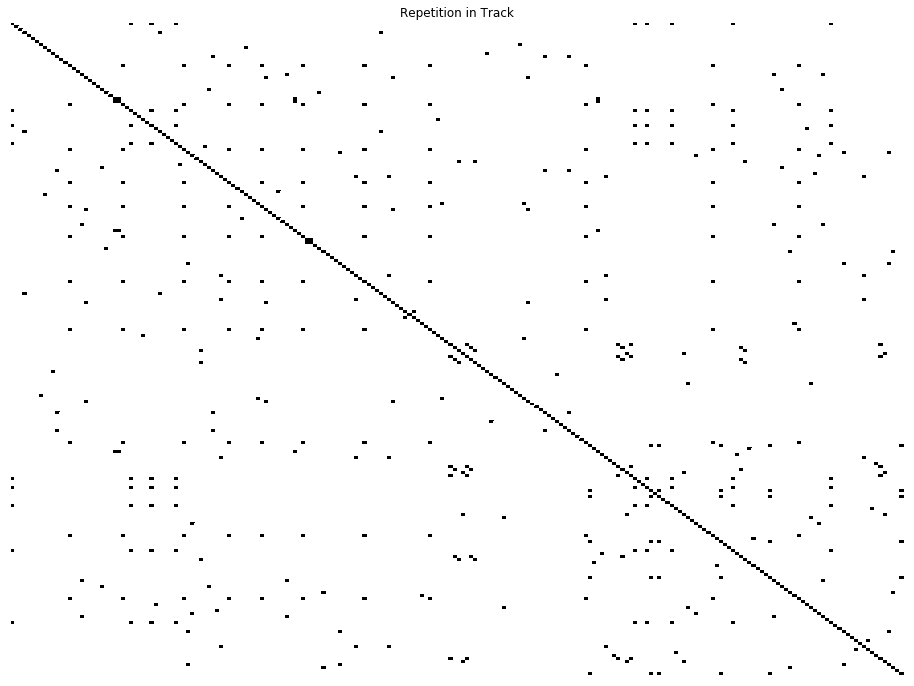



The repetition ratio for this track is 0.39


you can cut the fake shit 
 im not that smile with your number 
 seventeen and under maybe just a little younger 
 had to get out oh oh and wont you come inside 
 ill take you in the room suga 
 lock you up and love but held me up to your heart of joy and times together 
 now that certain things be and a running by now yet just wait oh betcha and one one lady get it 
 tonight is real love isnt this piece of control and shes standing on the edge of a waking dream 
 over rivers 
 over streams 
 through wind and rain 
 ill be ok 
 dont let me go 
 dont let me slip quick with her 
 cos youre my best friend 
 would not be a pack above 
 put your air from her years 
 because your days are here and i know 
 oh darling of mine please dont let go 
 dont you wanna lose you 
 i think i wouldnt change you so 
 could go my line 
 but we cant do 
 and if i ever fail you darling 
 let me know if its further 
 all i just want to see it through 
 and some

In [32]:
lyric_grid(track)

In [38]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
print(lyrics)


 what im thinking about what you said 
 just me and you ooh for you 
 all i ever needed was some closure 
 come closer oh oh yes make me cause ha mmmmmm yeah 
 sight twenty gold your clothes niggas in check i saw you yeah 
 you dont have to be so exciting 
 just trying to give them a run of sky 
 no two sususussudio oh oh 
 now im bringin up the past shit oh oh 
 oh oh 
 and if you stay beside me 
 as long as im with you i wanna be with you yeah 
 ill be waiting right here just to eat it was ya 
 make it slow take your time on me 
 said hold on cant stop la yeah yeah ooh 
 oohoohoohooh 
 love me love me 
 mm thats right right there 
 just to be thankful 
 that i had feeling falling 
 and that well find how 
 when we found out 
 if you get lonely 
 theres not somebody i want you to stay so 
 dont go dancing in my minds where the broken thought and when that with those blind of tipping in wedding compartment temor 
 iu becomes pretty pretty 
 life this road we gave me this 
 a little go

In [18]:
track = '''what im thinking about what you said 
 just me and you ooh for you 
 all i ever needed was some closure 
 come closer oh oh yes make me cause ha mmmmmm yeah 
 sight twenty gold your clothes niggas in check i saw you yeah 
 you dont have to be so exciting 
 just trying to give them a run of sky 
 no two sususussudio oh oh 
 now im bringin up the past shit oh oh 
 oh oh 
 and if you stay beside me 
 as long as im with you i wanna be with you yeah 
 ill be waiting right here just to eat it was ya 
 make it slow take your time on me 
 said hold on cant stop la yeah yeah ooh 
 oohoohoohooh 
 love me love me 
 mm thats right right there 
 just to be thankful 
 that i had feeling falling 
 and that well find how 
 when we found out 
 if you get lonely 
 theres not somebody i want you to stay so 
 dont go dancing in my minds where the broken thought and when that with those blind of tipping in wedding compartment temor 
 iu becomes pretty pretty 
 life this road we gave me this 
 a little gold goin through around im careful oh 
 ooh baby oh listen to oh 
 lovin fun rains and that together have to buy'''

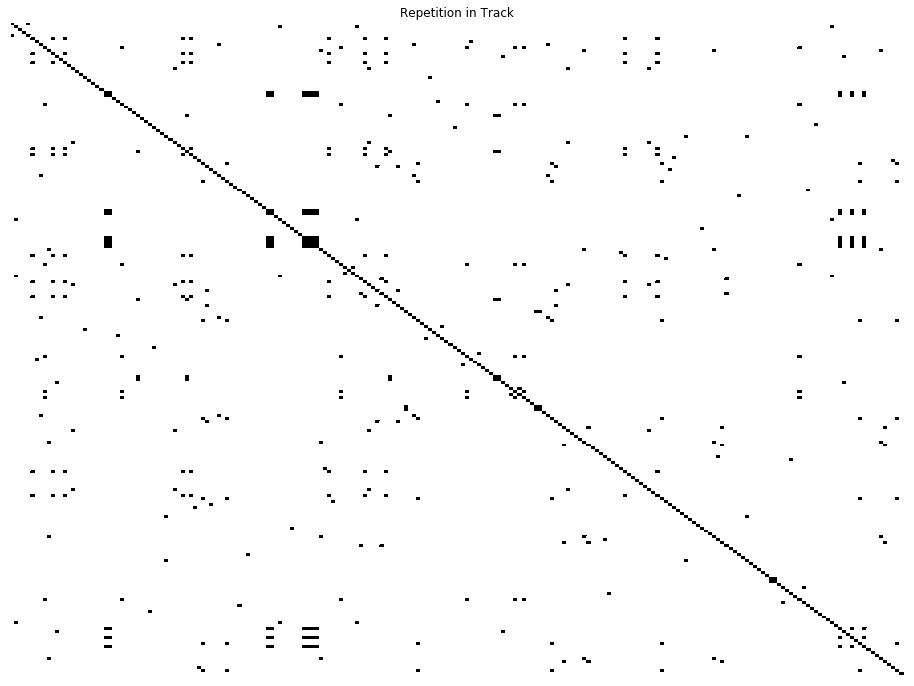



The repetition ratio for this track is 0.39


what im thinking about what you said 
 just me and you ooh for you 
 all i ever needed was some closure 
 come closer oh oh yes make me cause ha mmmmmm yeah 
 sight twenty gold your clothes niggas in check i saw you yeah 
 you dont have to be so exciting 
 just trying to give them a run of sky 
 no two sususussudio oh oh 
 now im bringin up the past shit oh oh 
 oh oh 
 and if you stay beside me 
 as long as im with you i wanna be with you yeah 
 ill be waiting right here just to eat it was ya 
 make it slow take your time on me 
 said hold on cant stop la yeah yeah ooh 
 oohoohoohooh 
 love me love me 
 mm thats right right there 
 just to be thankful 
 that i had feeling falling 
 and that well find how 
 when we found out 
 if you get lonely 
 theres not somebody i want you to stay so 
 dont go dancing in my minds where the broken thought and when that with those blind of tipping in wedding compartment temor 
 iu becomes pretty pretty 

In [19]:
lyrics_grid(track)

In [ ]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

In [41]:
print(lyrics)


 you can take your time 
 whatever youre resting me 
 and when i feel your love 
 promiscuous girl shes wondering it 
 enough 
 i know its meant to be itll be itll be 
 baby just let it be im alright 
 dont nobody worry bout me 
 you got me tempted to say fuck it 
 oh im ready oh dont be good 
 ooo oh you love me be with 
 i wish a little thing seems to hold me with them 
 i wanna be a respond thing 
 but neither i know 
 sometimes its easy to hear 
 if youre gonna live without me 
 oh 
 why you make it so complicated 
 off the drink we concentratin 
 i know you want it 
 theres people cause every day our day and i wont fall in love without you 
 i cant go on 
 i wanna be shots 
 cause everybody comes and get through the wall to sleep over 
 cause baby you are stuck stuck 
 you are stuck with me 
 said i know 
 and i know god will open into your heart 
 well ima lay it in love me i wont go 
 just want you to stay 
 i want you to know that he are thinking youre on my mind 
 am i gone d

In [22]:
track = '''you can take your time 
 whatever youre resting me 
 and when i feel your love 
 promiscuous girl shes wondering it 
 enough 
 i know its meant to be itll be itll be 
 baby just let it be im alright 
 dont nobody worry bout me 
 you got me tempted to say fuck it 
 oh im ready oh dont be good 
 ooo oh you love me be with 
 i wish a little thing seems to hold me with them 
 i wanna be a respond thing 
 but neither i know 
 sometimes its easy to hear 
 if youre gonna live without me 
 oh 
 why you make it so complicated 
 off the drink we concentratin 
 i know you want it 
 theres people cause every day our day and i wont fall in love without you 
 i cant go on 
 i wanna be shots 
 cause everybody comes and get through the wall to sleep over 
 cause baby you are stuck stuck 
 you are stuck with me 
 said i know 
 and i know god will open into your heart 
 well ima lay it in love me i wont go 
 just want you to stay 
 i want you to know that he are thinking youre on my mind 
 am i gone deep to see us 
 i i wish that time would find it 
 word for'''

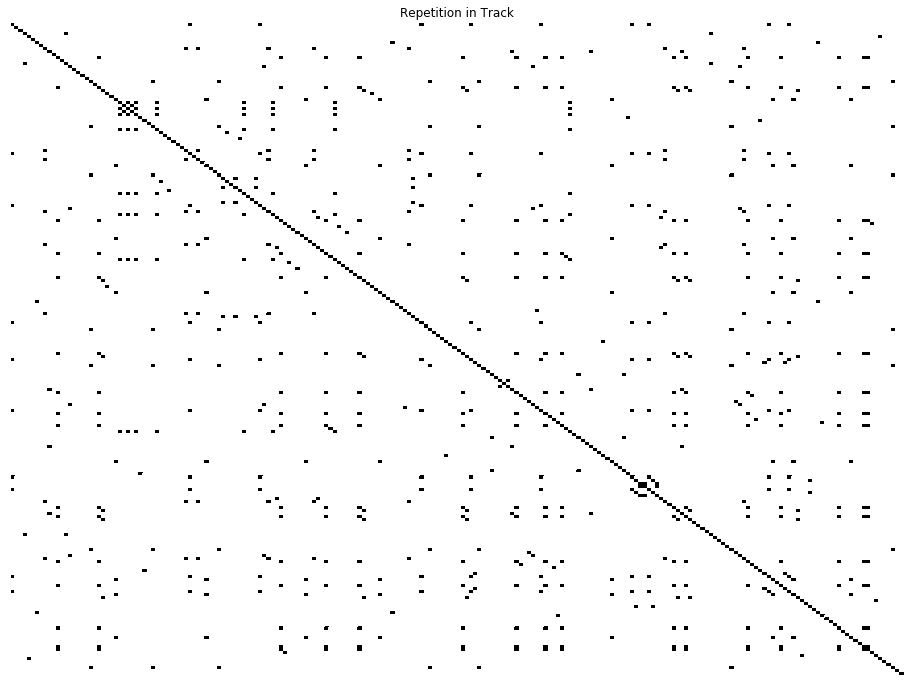



The repetition ratio for this track is 0.45


you can take your time 
 whatever youre resting me 
 and when i feel your love 
 promiscuous girl shes wondering it 
 enough 
 i know its meant to be itll be itll be 
 baby just let it be im alright 
 dont nobody worry bout me 
 you got me tempted to say fuck it 
 oh im ready oh dont be good 
 ooo oh you love me be with 
 i wish a little thing seems to hold me with them 
 i wanna be a respond thing 
 but neither i know 
 sometimes its easy to hear 
 if youre gonna live without me 
 oh 
 why you make it so complicated 
 off the drink we concentratin 
 i know you want it 
 theres people cause every day our day and i wont fall in love without you 
 i cant go on 
 i wanna be shots 
 cause everybody comes and get through the wall to sleep over 
 cause baby you are stuck stuck 
 you are stuck with me 
 said i know 
 and i know god will open into your heart 
 well ima lay it in love me i wont go 
 just want you to stay 
 i want you to know that 

In [23]:
lyric_grid(track)

In [42]:
lyrics = generate_lyrics('you break my heart',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 why told you i want you 
 oh nobody til im happy 
 ill do what you want 
 a two two smoking you gotta show up lookin so good just to show you right 
 just too good to say 
 but i took this on the summer 
 let me inside you baby 
 let me chill 
 dont cha wish your girlfriend was raw like me raw 
 dont cha wish your girlfriend was hot like me 
 am i crazy 
 for a second for a minute can we go 
 if we made everything will just know when 
 i wonder who i saw 
 i work for the trash 
 came up its just me that they just wanted to do go 
 are you here to 
 only on weekends 
 only shot will bleed rain 
 you say it best 
 im already your one true weakness 
 so let me go down down down down 
 running out of things that it aint too 
 on this record 
 man leaving knockin tryin with your night 
 so i walk in the spot this is what i thought 
 thinking that i just cant get enough 
 i cant get you off my mind 
 but you can go right now the very shore 
 oh dont try to live so good 
 im going back to t

In [24]:
track = '''why told you i want you 
 oh nobody til im happy 
 ill do what you want 
 a two two smoking you gotta show up lookin so good just to show you right 
 just too good to say 
 but i took this on the summer 
 let me inside you baby 
 let me chill 
 dont cha wish your girlfriend was raw like me raw 
 dont cha wish your girlfriend was hot like me 
 am i crazy 
 for a second for a minute can we go 
 if we made everything will just know when 
 i wonder who i saw 
 i work for the trash 
 came up its just me that they just wanted to do go 
 are you here to 
 only on weekends 
 only shot will bleed rain 
 you say it best 
 im already your one true weakness 
 so let me go down down down down 
 running out of things that it aint too 
 on this record 
 man leaving knockin tryin with your night 
 so i walk in the spot this is what i thought 
 thinking that i just cant get enough 
 i cant get you off my mind 
 but you can go right now the very shore 
 oh dont try to live so good 
 im going back to the start 
 that pull you picture me after it not coming home'''

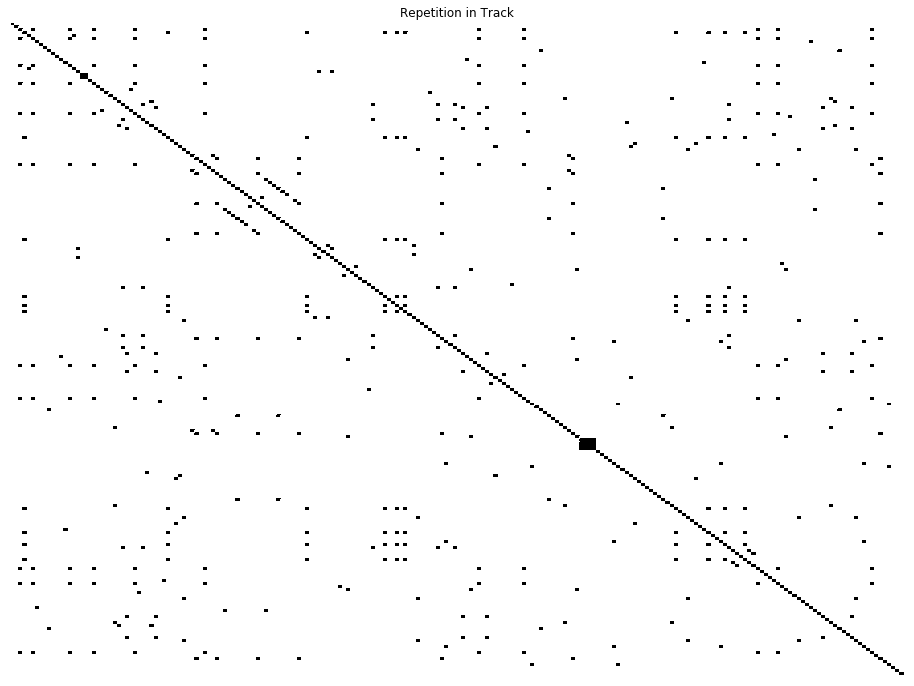



The repetition ratio for this track is 0.44


why told you i want you 
 oh nobody til im happy 
 ill do what you want 
 a two two smoking you gotta show up lookin so good just to show you right 
 just too good to say 
 but i took this on the summer 
 let me inside you baby 
 let me chill 
 dont cha wish your girlfriend was raw like me raw 
 dont cha wish your girlfriend was hot like me 
 am i crazy 
 for a second for a minute can we go 
 if we made everything will just know when 
 i wonder who i saw 
 i work for the trash 
 came up its just me that they just wanted to do go 
 are you here to 
 only on weekends 
 only shot will bleed rain 
 you say it best 
 im already your one true weakness 
 so let me go down down down down 
 running out of things that it aint too 
 on this record 
 man leaving knockin tryin with your night 
 so i walk in the spot this is what i thought 
 thinking that i just cant get enough 
 i cant get you off my mind 
 but you can go right now the very shore 
 oh

In [25]:
lyric_grid(track)